In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as dist
from torch import nn
from matplotlib.widgets import Slider
from tqdm.auto import tqdm

torch.cuda.set_device(f"cuda:{np.random.randint(0, 3)}")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

def elbo(y, sigma, loc_z, scale_z, loc_x, scale_x, alpha):
    y, sigma, loc_z, scale_z, loc_x, scale_x, alpha = map(torch.as_tensor, [y, sigma, loc_z, scale_z, loc_x, scale_x, alpha])
    mean_sq_z = loc_z ** 2 + scale_z ** 2
    mean_sq_x = loc_x ** 2 + scale_x ** 2
    one_minus_alpha = 1 - alpha

    moment_1 = loc_z * alpha
    moment_2 = (scale_z * alpha) ** 2
    moment_3 = loc_z * one_minus_alpha
    moment_4 = (scale_z * one_minus_alpha) ** 2
    
    first = - mean_sq_z / 2 - moment_1
    second = - mean_sq_x * torch.exp(2 * (moment_2 - moment_1)) / 2
    third = y * loc_x * torch.exp(moment_3 + moment_4 / 2) / (sigma ** 2)
    fourth = - mean_sq_x * torch.exp(2 * (moment_3 + moment_4)) / (2 * sigma ** 2)
    fifth = torch.log(scale_z) + torch.log(scale_x)

    return first + second + third + fourth + fifth

  0%|          | 0/10000 [00:00<?, ?it/s]

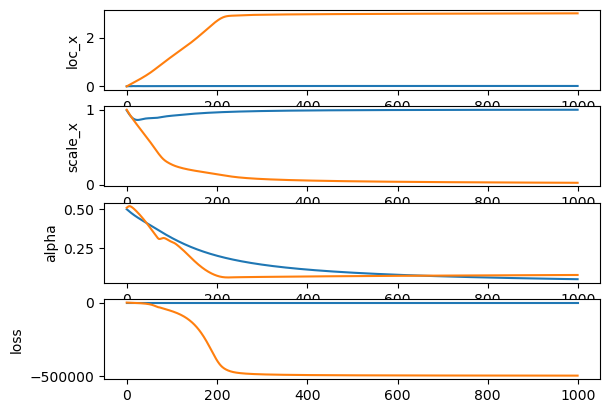

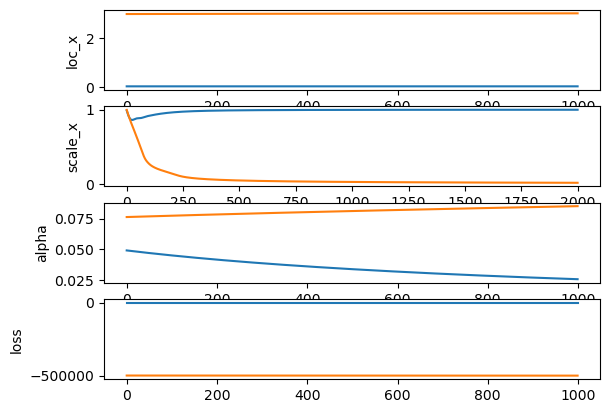

KeyboardInterrupt: 

In [2]:
%matplotlib inline
# bound = 100
# step = 1
# y, sigma = torch.meshgrid(
#     torch.linspace(-bound, bound, step),
#     torch.linspace(0.1, bound, step),
#     indexing = "ij"
# )

y = torch.Tensor([100, 100])
sigma = torch.Tensor([100, 0.1])

loc_z = nn.Parameter(torch.zeros(len(y)).normal_() / 100)
log_scale_z = nn.Parameter(torch.zeros(len(y)).normal_() / 100)
# loc_x = nn.Parameter(torch.Tensor([100]))
loc_x = nn.Parameter(torch.zeros(len(y)).normal_() / 100)
log_scale_x = nn.Parameter(torch.zeros(len(y)).normal_() / 100)
alpha = nn.Parameter(torch.zeros(len(y)).normal_() / 100)

optim = torch.optim.Adam([loc_z, log_scale_z, loc_x, log_scale_x], lr=1e-2)
optim_alpha = torch.optim.Adam([alpha], lr=1e-2)
args = []

loc_xs = []
scale_xs = []
alphas = []
losses = []
epoch = tqdm(range(10000))
for i in epoch:
    optim.zero_grad()
    optim_alpha.zero_grad()
    loss = - elbo(y, sigma, loc_z, log_scale_z.exp(), loc_x, log_scale_x.exp(), alpha.sigmoid())
    loss.mean().backward()
    optim.step()
    optim_alpha.step()
    epoch.set_description("Loss: {:.4f}".format(loss.mean()))
    loc_xs.append(loc_x.detach().cpu().numpy())
    scale_xs.append(log_scale_x.exp().detach().cpu().numpy())
    alphas.append(alpha.sigmoid().detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

    if (i + 1) % (len(epoch) // 10) == 0:
        fig, axes = plt.subplots(4, 1)
        axes[0].plot(np.array(loc_xs))
        axes[0].set_ylabel("loc_x")
        axes[1].plot(np.array(scale_xs))
        axes[1].set_ylabel("scale_x")
        axes[2].plot(np.array(alphas))
        axes[2].set_ylabel("alpha")
        axes[3].plot(np.array(losses))
        axes[3].set_ylabel("loss")
        plt.show()
        
        loc_xs = []
        alphas = []
        losses = []

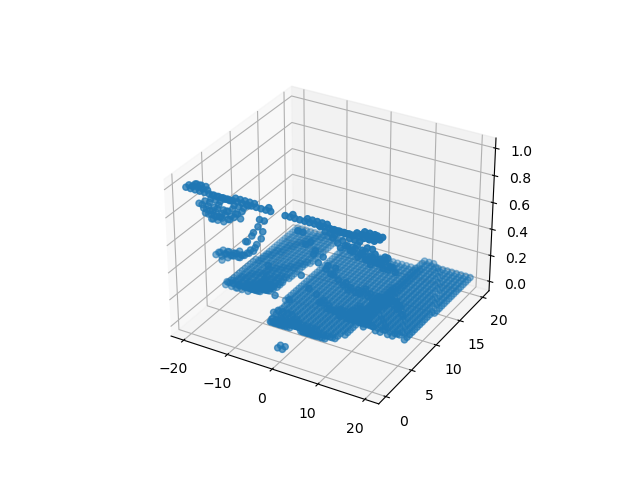

In [2]:
%matplotlib widget
plt.clf()
ax = plt.subplot(projection="3d")
fig = ax.get_figure()

bound = 20
step = 40
ys, sigmas, alphas, loc_zs, loc_xs = torch.meshgrid(
    torch.linspace(-bound, bound, step),
    torch.linspace(0.1, bound, step),
    torch.linspace(0, 1, step),
    torch.linspace(-bound, bound, step),
    torch.linspace(-bound, bound, step),
    indexing = "ij"
)

e = elbo(ys, sigmas, loc_zs, 1, loc_xs, 1, alphas)

index = (torch.arange(step)[:,None], torch.arange(step)[None,:], torch.argmax(e.reshape(step, step, -1), axis=-1))
ys = ys.reshape(step, step, -1)[index]
sigmas = sigmas.reshape(step, step, -1)[index]
alphas = alphas.reshape(step, step, -1)[index]

ax.scatter(ys.detach().cpu().numpy(), sigmas.detach().cpu().numpy(), alphas.detach().cpu().numpy())
plt.show()

/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


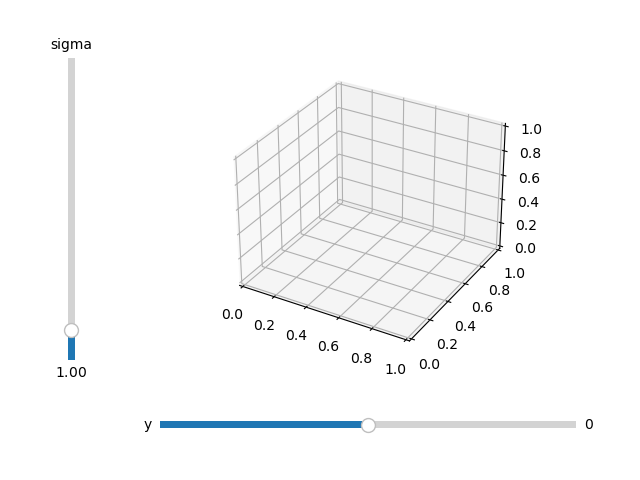

In [ ]:
%matplotlib widget

def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = torch.div(index, dim, rounding_mode="floor")
    return tuple(reversed(out))

plt.clf()
ax = plt.subplot(projection="3d")
fig = ax.get_figure()
fig.subplots_adjust(left=0.25, bottom=0.25)

bound = 100
step = 30
loc_xs, alphas = torch.meshgrid(
    torch.linspace(-bound, bound, step),
    torch.linspace(0, 1, step),
)

axyy = fig.add_axes([0.25, 0.1, 0.65, 0.03])
y_slider = Slider(
    ax=axyy,
    label="y",
    valmin=-bound,
    valmax=bound,
    valinit=0,
)

axss = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
sigma_slider = Slider(
    ax=axss,
    label="sigma",
    valmin=0.01,
    valmax=bound / 10,
    valinit=1,
    orientation="vertical"
)

def update(val):
    ax.clear()
    e = elbo(y_slider.val, sigma_slider.val, 0, 1, loc_xs, 1, alphas)
    ax.scatter(loc_xs.detach().cpu().numpy(), alphas.detach().cpu().numpy(), e.detach().cpu().numpy(), alpha=0.1)
    index = unravel_index(torch.argmax(e), e.shape)
    ax.scatter(loc_xs[index].detach().cpu().numpy(), alphas[index].detach().cpu().numpy(), e[index].detach().cpu().numpy(), c="red")

y_slider.on_changed(update)
sigma_slider.on_changed(update)
plt.show()